In [1]:
# Import necessary libraries
import pandas as pd

# File paths for the uploaded datasets
customers_file = 'customers.csv'
products_file = 'Products.csv'
transactions_file = 'Transactions.csv'

# Load datasets
customers = pd.read_csv(customers_file)
products = pd.read_csv(products_file)
transactions = pd.read_csv(transactions_file)

In [2]:
# Display the first few rows of each dataset to check the structure and contents
customers_head = customers.head(2)
products_head = products.head(2)
transactions_head = transactions.head(2)

(customers_head, products_head, transactions_head)

(  CustomerID      CustomerName         Region  SignupDate
 0      C0001  Lawrence Carroll  South America  2022-07-10
 1      C0002    Elizabeth Lutz           Asia  2022-02-13,
   ProductID            ProductName     Category  Price
 0      P001   ActiveWear Biography        Books  169.3
 1      P002  ActiveWear Smartwatch  Electronics  346.3,
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0        T00001      C0199      P067  2024-08-25 12:38:23         1   
 1        T00112      C0146      P067  2024-05-27 22:23:54         1   
 
    TotalValue   Price  
 0      300.68  300.68  
 1      300.68  300.68  )

In [3]:
customers_missing = customers.isnull().sum()
products_missing = products.isnull().sum()
transactions_missing = transactions.isnull().sum()

(customers_missing, products_missing, transactions_missing)

(CustomerID      0
 CustomerName    0
 Region          0
 SignupDate      0
 dtype: int64,
 ProductID      0
 ProductName    0
 Category       0
 Price          0
 dtype: int64,
 TransactionID      0
 CustomerID         0
 ProductID          0
 TransactionDate    0
 Quantity           0
 TotalValue         0
 Price              0
 dtype: int64)

In [19]:
# Convert date columns to datetime format
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'], errors='coerce')
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'], errors='coerce')

In [21]:
# Recalculate TotalValue where it doesn't match Price * Quantity
transactions['TotalValue'] = transactions.apply(
    lambda row: row['Price'] * row['Quantity'] if row['TotalValue'] != row['Price'] * row['Quantity'] else row['TotalValue'],
    axis=1
)

# Count of rows before and after cleaning
original_row_count = len(transactions)

print("number of rows in the tranasction data having integrity issues= "+str(original_row_count))



# merge datasets after removing integrity issues
clean_transactions_products = transactions.merge(products, on='ProductID', how='left')
clean_merged_data = clean_transactions_products.merge(customers, on='CustomerID', how='left')

# Check the first few rows of the cleaned merged dataset
clean_merged_data.head(5)

number of rows in the tranasction data having integrity issues= 1000


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,ProductName,Category,Price_y,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Timothy Perez,Europe,2022-03-15


In [23]:
from datetime import datetime

# Feature engineering: Aggregating data by CustomerID
customer_features = clean_merged_data.groupby('CustomerID').agg(
    TotalSpending=('TotalValue', 'sum'),                # Total spending per customer
    NumTransactions=('TransactionID', 'nunique'),      # Number of transactions
    AvgSpendingPerTransaction=('TotalValue', 'mean'),  # Average spending per transaction
    DaysSinceLastPurchase=(
        'TransactionDate', 
        lambda x: (datetime.now() - x.max()).days       # Days since last purchase
    ),
    DaysSinceSignup=(
        'SignupDate', 
        lambda x: (datetime.now() - x.min()).days       # Days since signup
    )
).reset_index()

# Display the aggregated customer-level features
customer_features.head()


,CustomerID,TotalSpending,NumTransactions,AvgSpendingPerTransaction,DaysSinceLastPurchase,DaysSinceSignup
0,C0001,3354.52,5,670.904,86,932
1,C0002,1862.74,4,465.685,55,1079
2,C0003,2725.38,4,681.345,155,326
3,C0004,5354.88,8,669.360,35,841
4,C0005,2034.24,3,678.080,84,896


In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Normalize the features for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop(columns=["CustomerID"]))

# Apply K-Means clustering with different cluster sizes (2 to 10) and evaluate DB Index
results = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, labels)
    results.append((n_clusters, db_index))

# Create a DataFrame to store the results
db_index_df = pd.DataFrame(results, columns=["NumClusters", "DBIndex"])
db_index_df.sort_values("DBIndex", ascending=True, inplace=True)

# Reset the index to remove the default index column
db_index_df = db_index_df.reset_index(drop=True)

# Display the cleaned DataFrame
print(db_index_df)


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

   NumClusters   DBIndex
0           10  1.141978
1            8  1.168368
2            9  1.171877
3            7  1.186953
4            5  1.187702
5            6  1.220782
6            4  1.287697
7            3  1.387530
8            2  1.541226


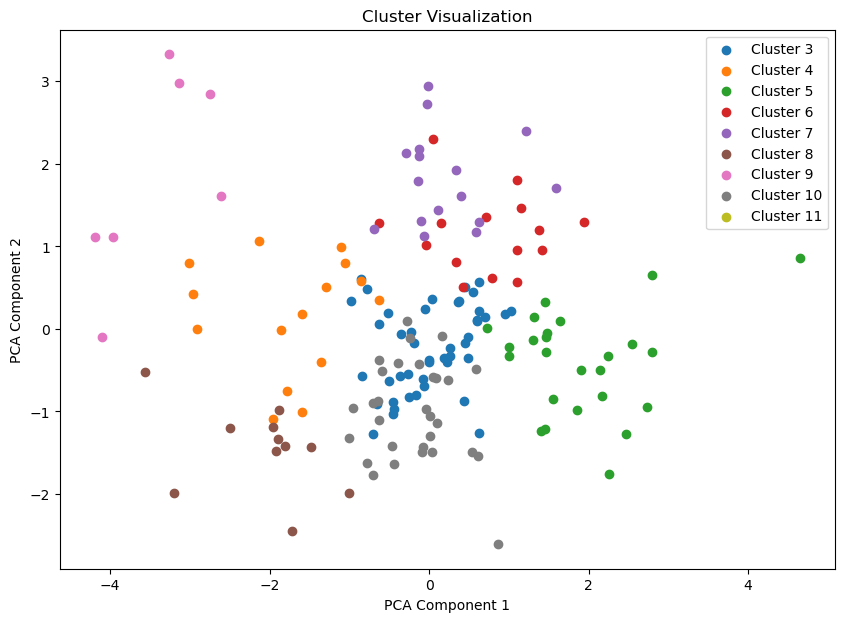

In [37]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce features to 2D using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Plot clusters
plt.figure(figsize=(10, 7))
for cluster in range(2,11):  # Use the number of clusters you chose
    cluster_points = reduced_features[labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster + 1}')

plt.title('Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


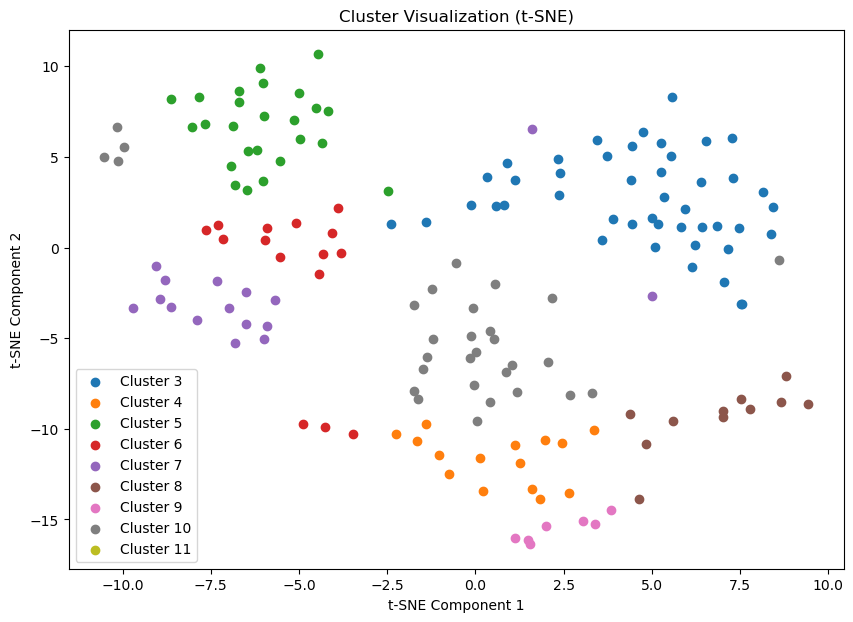

In [38]:
from sklearn.manifold import TSNE

# Reduce features to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
reduced_tsne = tsne.fit_transform(scaled_features)

# Plot clusters
plt.figure(figsize=(10, 7))
for cluster in range(2,11):
    cluster_points = reduced_tsne[labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster + 1}')
    
plt.title('Cluster Visualization (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()
